In [ ]:
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('kc_house_data.csv')

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.dtypes

#### Meanings

- id - Unique ID for each home sold
- date - Date of the home sale
- price - Price of each home sold
- bedrooms - Number of bedrooms
- bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower
- sqft_living - Square footage of the apartment interior living space
- sqft_lot - Square footage of the land space
- floors - Number of floors
- waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not
- view - An index from 0 to 4 of how good the view of the property was
- condition - An index from 1 to 5 on the condition of the apartment
- grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high-quality level of construction and design
- sqft_above - The square footage of the interior housing space that is above ground level
- sqft_basement - The square footage of the interior housing space that is below ground level
- yr_built - The year the house was initially built
- yr_renovated - The year of the house’s last renovation
- zipcode - What zipcode area the house is in
- lat - Latitude
- long - Longitude
- sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors
- sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors


## EDA

- Eliminar las columnas de id y date ya que para la implementación de esta red neuronal, no tendrán gran relevancia

In [ ]:
df.drop(columns=['id', 'date'], inplace=True)

In [ ]:
df

In [ ]:
df.describe()

In [ ]:
print(df.dtypes)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# sns.pairplot(data=df)
# plt.show()

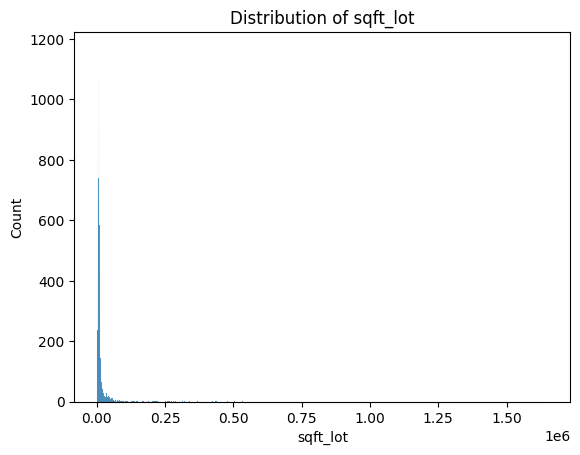

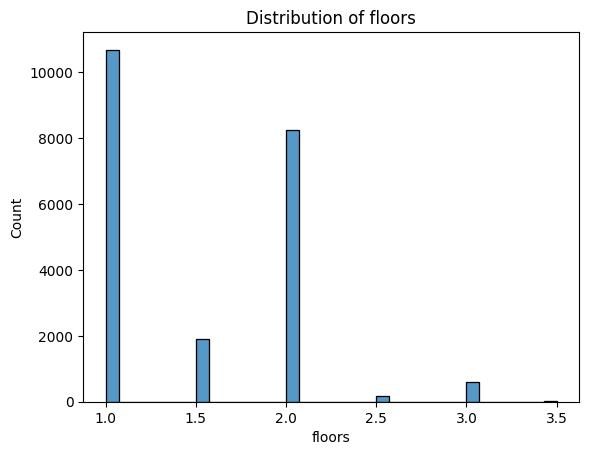

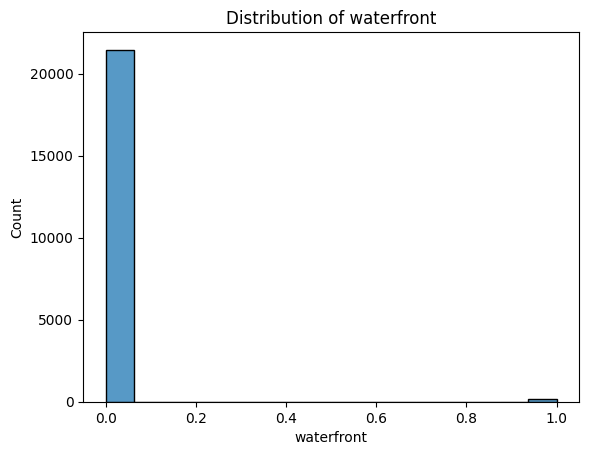

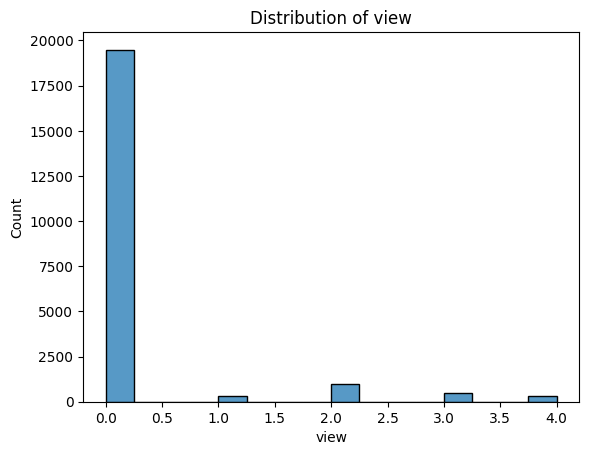

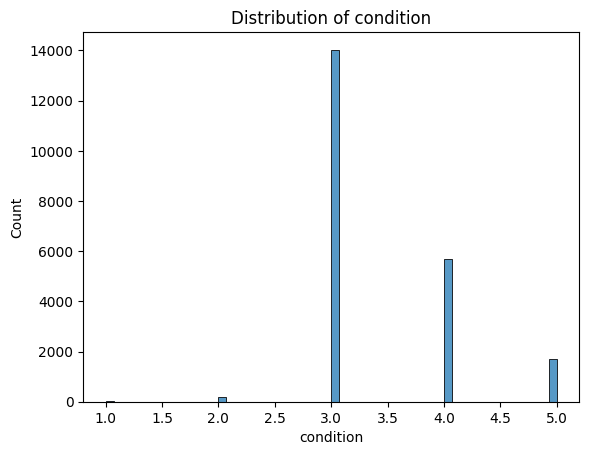

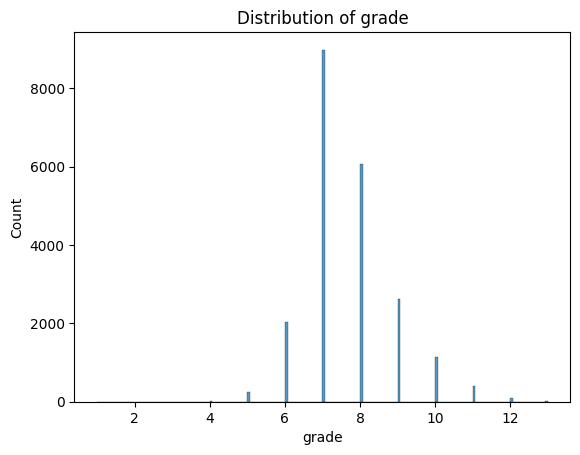

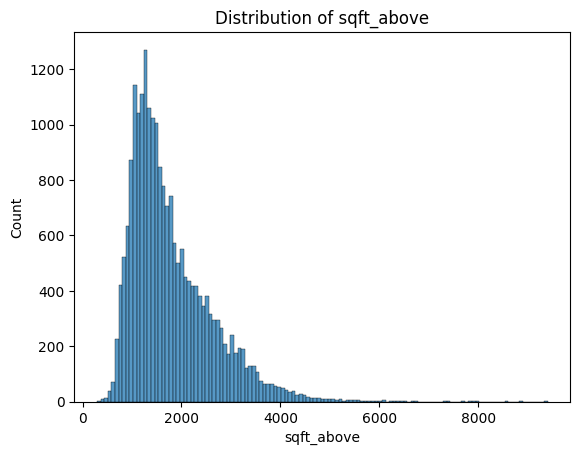

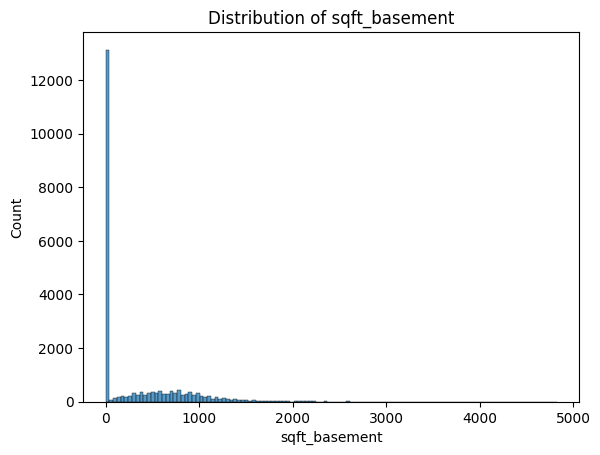

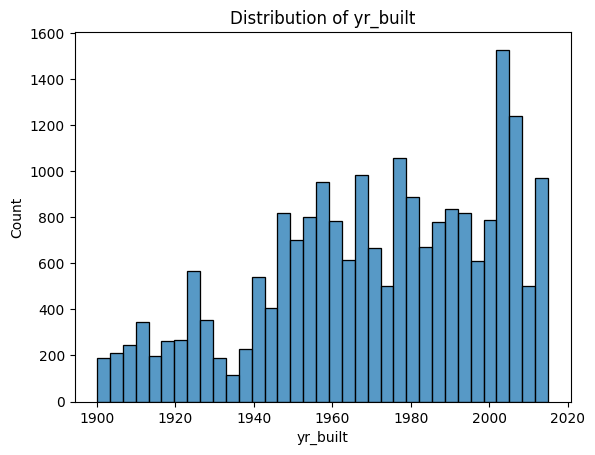

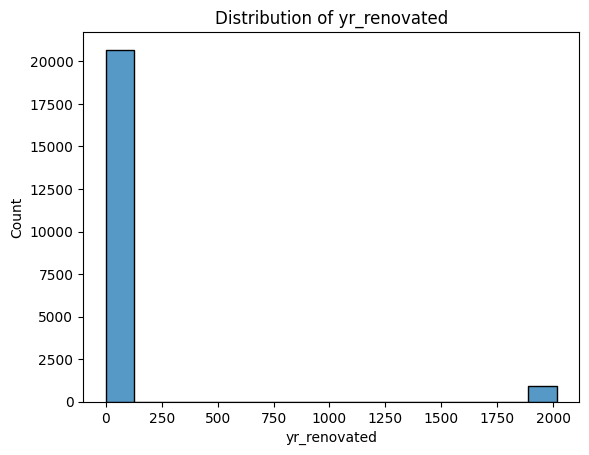

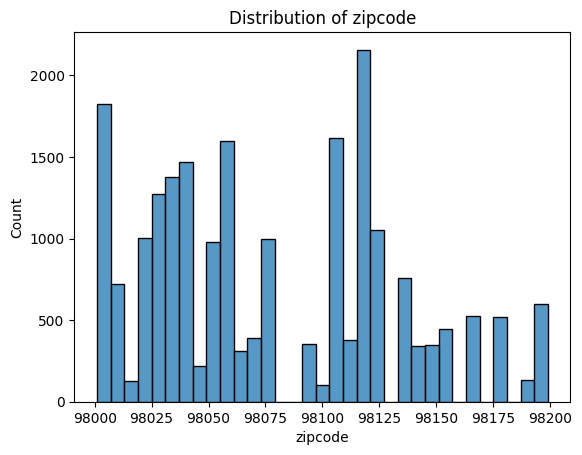

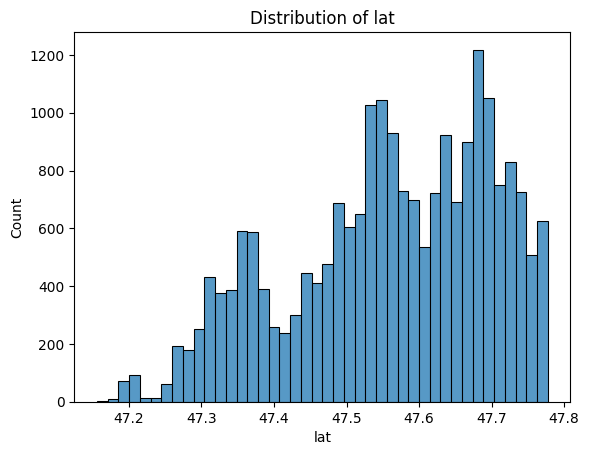

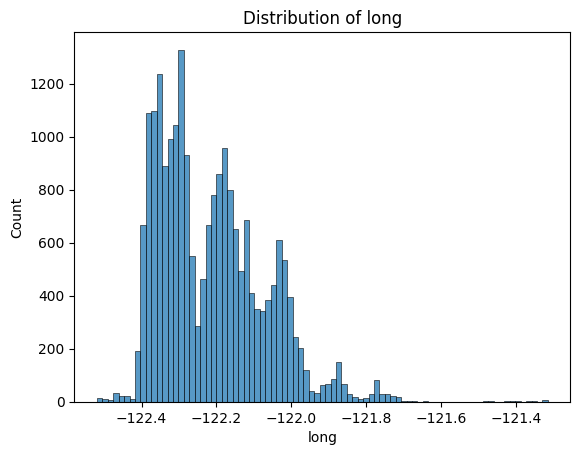

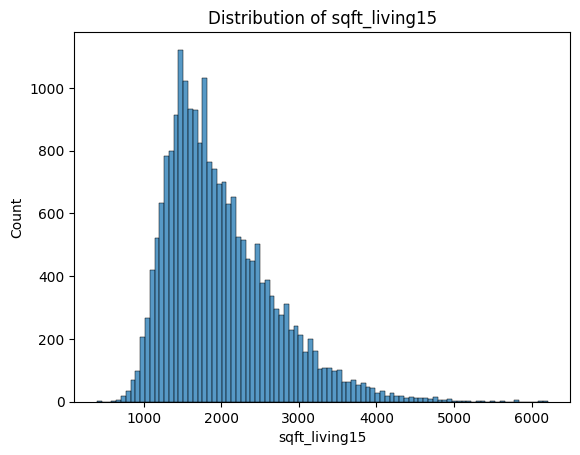

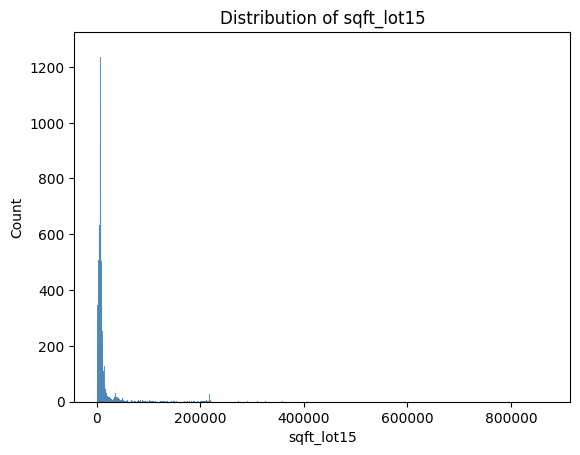

In [204]:
def plot_hist(df, columns):
    for column in columns:
        sns.histplot(data=df, x=column)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.show()

to_plot = [column for column in df.columns if df[column].dtype in ['int64', 'float64']]

plot_hist(df, to_plot)


#### Preprocess

* Identificar la cantidad de outliers en la dimensión objetivo [x]
* Estandarizar

In [205]:
Q1 = np.percentile(df['price'], 25)
Q3 = np.percentile(df['price'], 75)
IQR = Q3 - Q1

# IQR method to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f'The lower and upper bounds for price dimension are: {lower_bound}, {upper_bound}')

The lower and upper bounds for price dimension are: -162625.0, 1129575.0


In [206]:
# Log scale
df.loc[:, 'price'] = np.log1p(df['price'])

# Filtering outliers from the price dimension
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

In [207]:
import numpy as np
# MinMax Scaler since we have the same unit in the prices and we do not follow an specific distribution
from sklearn.preprocessing import MinMaxScaler

scaler_price = MinMaxScaler()

prices = np.array(df['price']).reshape(-1, 1)

normalized_prices = scaler_price.fit_transform(prices)

df.loc[:, 'price'] = normalized_prices

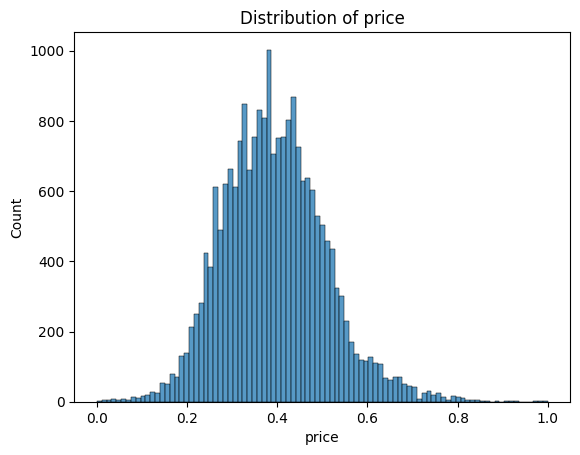

In [208]:
plot_hist(df, ['price'])

#### Preprocess first inputs (sqft_living, sqft_lot)

In [209]:
def get_bounds(df, columns):
    for column in columns:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column], 75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        print(f'The lower and upper bounds for {column} dimension are: {lower_bound}, {upper_bound}')

get_bounds(df, ['sqft_living', 'sqft_lot', 'floors', 'bathrooms', 'bedrooms', 'grade', 'condition'])

The lower and upper bounds for sqft_living dimension are: -257.5, 4234.5
The lower and upper bounds for sqft_lot dimension are: -3432.0, 19160.0
The lower and upper bounds for floors dimension are: -0.5, 3.5
The lower and upper bounds for bathrooms dimension are: 0.625, 3.625
The lower and upper bounds for bedrooms dimension are: 1.5, 5.5
The lower and upper bounds for grade dimension are: 5.5, 9.5
The lower and upper bounds for condition dimension are: 1.5, 5.5


In [210]:
df.loc[:, 'sqft_living'] = np.log1p(df['sqft_living'])
df.loc[:, 'sqft_lot'] = np.log1p(df['sqft_lot'])
df.loc[:, 'floors'] = np.log1p(df['floors'])
df.loc[:, 'condition'] = np.log1p(df['condition'])
df.loc[:, 'grade'] = np.log1p(df['grade'])
df.loc[:, 'bathrooms'] = np.log1p(df['bathrooms'])
df.loc[:, 'bedrooms'] = np.log1p(df['bedrooms'])

/tmp/ipykernel_63194/3547961378.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[7.07411682 7.85205021 6.64768837 ... 6.92853782 7.37838371 6.92853782]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'sqft_living'] = np.log1p(df['sqft_living'])
/tmp/ipykernel_63194/3547961378.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[8.6395878  8.88779076 9.21044037 ... 7.20860034 7.77863015 6.98193468]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, 'sqft_lot'] = np.log1p(df['sqft_lot'])
/tmp/ipykernel_63194/3547961378.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.38629436 1.38629436 1.38629436 ... 1.38629436 1.38629436 1.38629436]' has dtype incompatible with int

In [211]:
scaler_features = MinMaxScaler()
features = ['sqft_living', 'sqft_lot', 'bedrooms', 'bathrooms', 'condition', 'grade', 'view']
df[features] = scaler_features.fit_transform(df[features])

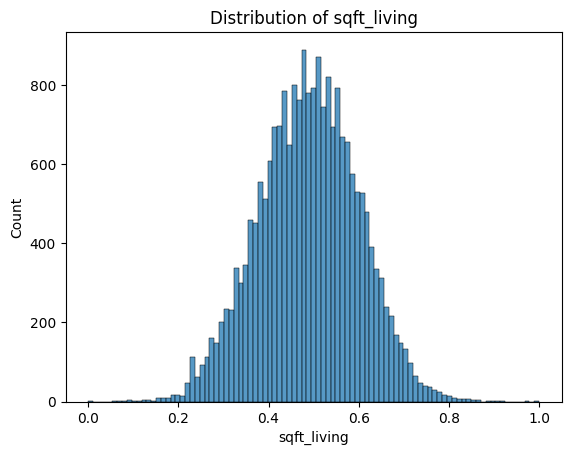

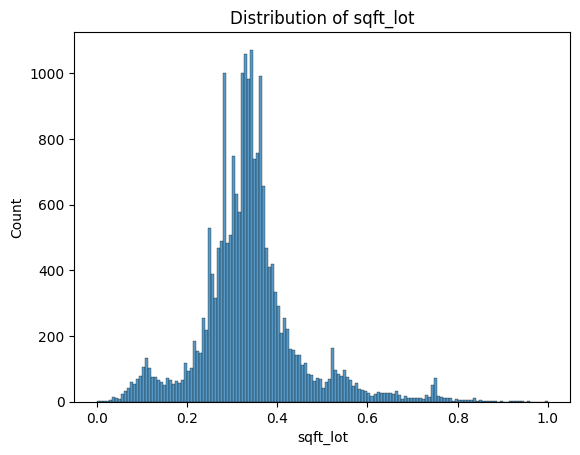

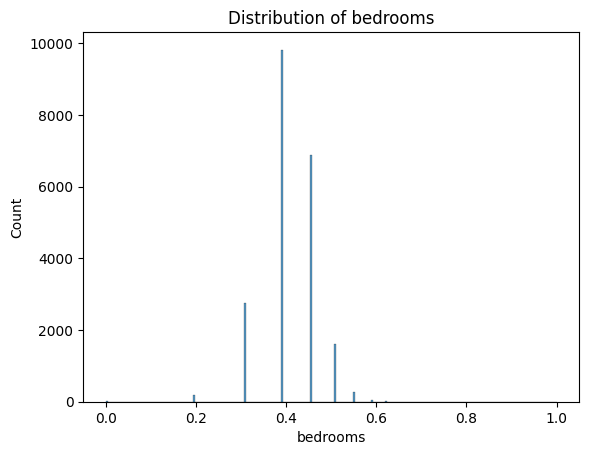

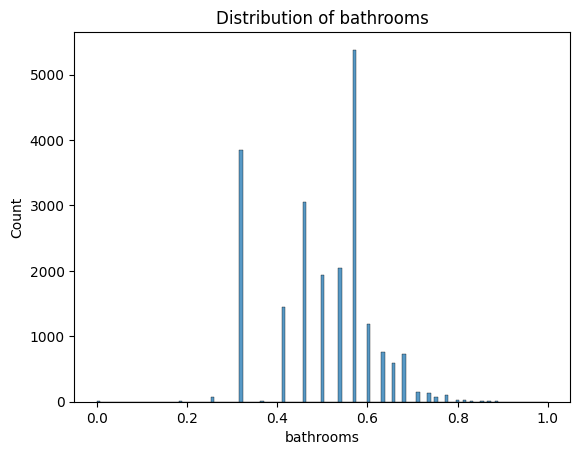

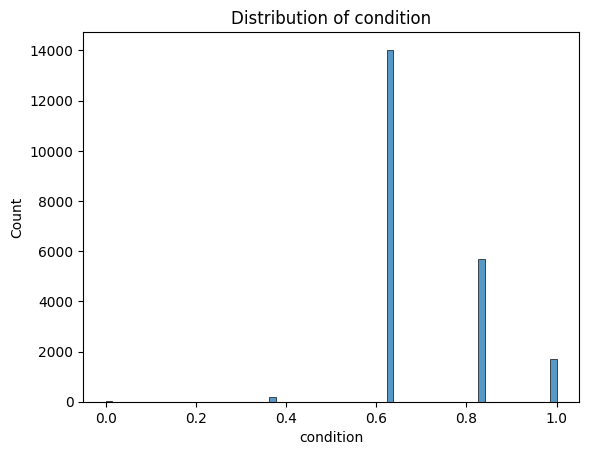

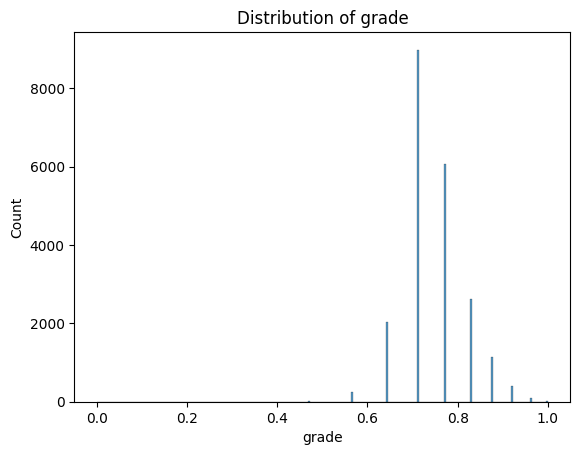

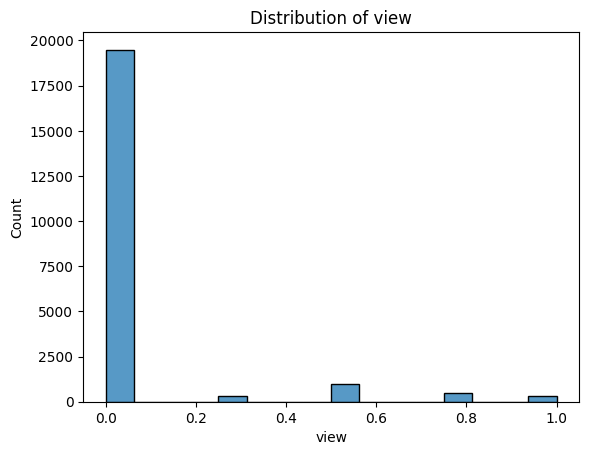

In [212]:
plot_hist(df, features)

## ANN

In [213]:
X = df[features]
y = df['price']

In [214]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [219]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras

# Build the neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2)


Epoch 1/200


/home/ismaelporto/ann/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0307 - val_loss: 0.0204
Epoch 2/200
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0088 - val_loss: 0.0127
Epoch 3/200
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0077 - val_loss: 0.0082
Epoch 4/200
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 5/200
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068 - val_loss: 0.0061
Epoch 6/200
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 7/200
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 8/200
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 9/200
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0061 - val_loss: 0.0061
Epoch 10/200
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0061 - val_loss: 0.0073
Epoch 11/200
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0060 - val_loss: 0.0063
Epoch 12/200
433/433 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0062
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step


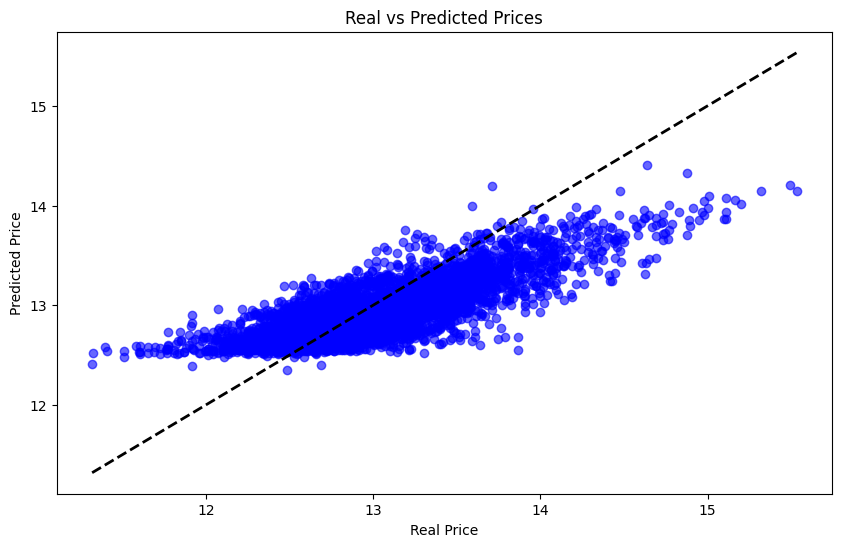

In [223]:
loss = model.evaluate(X_test, y_test)

norm_price_predictions = model.predict(X_test)

price_predictions = scaler_price.inverse_transform(norm_price_predictions).flatten()

actual_prices = scaler_price.inverse_transform(y_test.values.reshape(-1, 1)).flatten()

comparison_df = pd.DataFrame({
    'Predicted Price': price_predictions,
    'Actual Price': actual_prices
})

plt.figure(figsize=(10, 6))
plt.scatter(actual_prices, price_predictions, alpha=0.6, color='b')
plt.plot([actual_prices.min(), actual_prices.max()], [actual_prices.min(), actual_prices.max()], 'k--', lw=2)
plt.xlabel('Real Price')
plt.ylabel('Predicted Price')
plt.title('Real vs Predicted Prices')
plt.show()
